In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.compat.v2 as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report
#from imutils import paths
import pickle
import cv2
import os
import argparse
import pandas as pd
from PIL import Image
import glob


In [2]:
df_sports = pd.read_csv('data.csv')
df_sports.head(5)

,image_path,target
0,../input/data/gymnastics/00000774.jpg,9.0
1,../input/data/table_tennis/00000702.jpg,16.0
2,../input/data/fencing/00000275.jpg,6.0
3,../input/data/baseball/00000380.jpg,1.0
4,../input/data/cricket/00000303.jpg,5.0


In [3]:
dataset = []
labels = []

# Seleciona as possíveis labels que eu desejo escolher do dataset 
LABELS = set(["weight_lifting", "tennis", "football"])

# Procura no csv por cada path e cada target
for image_path, target in zip(df_sports['image_path'], df_sports['target']):
    
    # Separa o path e seleciona o esporte
    label = image_path.split('/')[-2]
    
    # Seleciona apenas as que estão contidas em LABELS
    if label not in LABELS:
        continue
        
    # Lê imagem
    image = cv2.imread(str(image_path))
    # Converte para RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # Redimensiona para 224x224
    image = cv2.resize(image, (224, 224))
    # Adiciona no vetor de imagens
    dataset.append(image)
    labels.append(label)
    
# Conversão para arrays
dataset = np.array(dataset)
labels = np.array(labels)    

In [4]:
dataset[0]

array([[[135, 134, 139],
        [145, 144, 149],
        [140, 139, 144],
        ...,
        [ 61,  61,  61],
        [ 59,  59,  57],
        [ 59,  59,  57]],

       [[149, 149, 151],
        [153, 153, 155],
        [155, 155, 157],
        ...,
        [ 62,  62,  62],
        [ 59,  59,  57],
        [ 60,  60,  58]],

       [[147, 147, 149],
        [150, 150, 151],
        [161, 161, 162],
        ...,
        [ 63,  63,  63],
        [ 62,  62,  60],
        [ 60,  60,  59]],

       ...,

       [[ 58,  59,  63],
        [ 56,  57,  62],
        [ 59,  60,  64],
        ...,
        [121, 118, 115],
        [122, 118, 115],
        [120, 116, 113]],

       [[ 59,  60,  64],
        [ 57,  58,  62],
        [ 61,  62,  66],
        ...,
        [117, 114, 112],
        [123, 119, 118],
        [118, 114, 113]],

       [[ 57,  58,  62],
        [ 60,  61,  65],
        [ 57,  58,  61],
        ...,
        [118, 114, 113],
        [118, 114, 113],
        [113, 109, 108]]

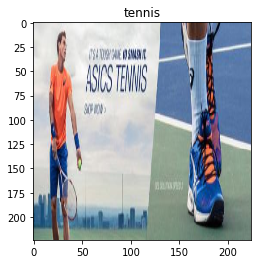

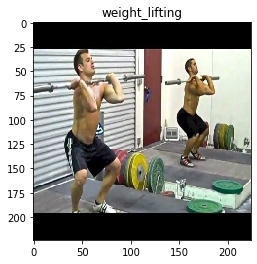

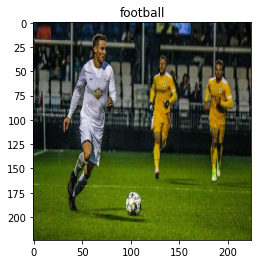

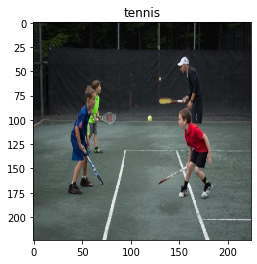

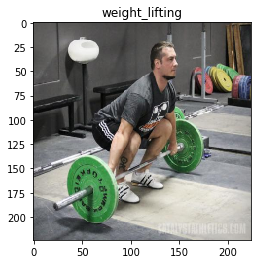

In [125]:
# Visualização do dataset e labels
for i in range(0,5):
    k = np.random.randint(0,dataset.shape[0])
    plt.figure(i+1)
    plt.imshow(dataset[k,:,:,:])
    plt.title(labels[k])

In [157]:
# One-hot Encoding
lb = LabelBinarizer()
labels_oh = lb.fit_transform(labels)

#Divide em treino e teste o dataset
x_train, x_test, y_train, y_test = train_test_split(dataset, labels_oh,test_size=0.25, stratify=labels, random_state=42)

In [173]:
# Aumento de dados - permite uma maior generalização no modelo, transformando diversos vezes a imagem, de forma que a label ainda continue a mesma
# Diminui chance de overfitting tambem
trainAug = tf.keras.preprocessing.image.ImageDataGenerator(
                rotation_range=30,
                zoom_range=0.15,
                width_shift_range=0.2,
                height_shift_range=0.2,
                shear_range=0.15,
                horizontal_flip=True,
                fill_mode="nearest")

valAug = tf.keras.preprocessing.image.ImageDataGenerator()

# Pesquisar sobre
# define the ImageNet mean subtraction (in RGB order) and set the
# the mean subtraction value for each of the data augmentation
# objects
mean = np.array([123.68, 116.779, 103.939], dtype="float32")
trainAug.mean = mean
valAug.mean = mean

In [174]:
# Visualiza se há 4 dimensões para o keras
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)



(1494, 224, 224, 3)
(499, 224, 224, 3)
(1494, 3)
(499, 3)


In [175]:
# Modelo da rede ResNet50 pré treinada 
base_model = tf.keras.applications.ResNet50(weights="imagenet", include_top=False,input_tensor=tf.keras.Input(shape=(224, 224, 3)))
# Não atualiza os pesos
for layer in base_model.layers:
    layer.trainable = False
# Modelo da rede, atualizando as outras camadas, menos a da ResNet50
p = tf.keras.Sequential([
                         base_model,
                         tf.keras.layers.AveragePooling2D (pool_size=(7, 7)),
                         tf.keras.layers.Flatten(),
                         tf.keras.layers.Dense(256, activation = 'relu'),
                         tf.keras.layers.Dropout(0.5),
                         tf.keras.layers.Dense(3, activation = 'softmax')
])

In [176]:
# Visualização das layers
p.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
average_pooling2d_4 (Average (None, 1, 1, 2048)        0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 256)               524544    
_________________________________________________________________
dropout_6 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 3)                 771       
Total params: 24,113,027
Trainable params: 525,315
Non-trainable params: 23,587,712
____________________________________

In [177]:
# Compilador
p.compile(
    optimizer=tf.keras.optimizers.SGD(lr=1e-4, momentum=0.9, decay=1e-4/50),
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

In [180]:
h = p.fit(trainAug.flow(x_train, y_train, batch_size=32),
          steps_per_epoch=len(x_train) // 32,
          validation_data=valAug.flow(x_test, y_test),
          validation_steps=len(x_test) // 32,
          epochs=10)



# Treina o modelo e avalia-o
#h = p.fit(x_train, y_train, batch_size = 32, epochs = 50, validation_data = (x_test, y_test), shuffle = True)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 46 steps, validate for 15 steps
Epoch 1/10
46/46 [==============================] - 855s 19s/step - loss: 1.3762 - accuracy: 0.3666 - val_loss: 1.0348 - val_accuracy: 0.5479
Epoch 2/10
46/46 [==============================] - 815s 18s/step - loss: 1.1095 - accuracy: 0.4884 - val_loss: 0.8278 - val_accuracy: 0.6521
Epoch 3/10
46/46 [==============================] - 862s 19s/step - loss: 0.9616 - accuracy: 0.5547 - val_loss: 0.6993 - val_accuracy: 0.7333
Epoch 4/10
18/46 [==========>...................] - ETA: 8:01 - loss: 0.9005 - accuracy: 0.5901

KeyboardInterrupt: 

In [ ]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

In [182]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16852717233274052553
]
